# Plots para la tesis

Imports


In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pathlib import Path

Paths a los archivos de resultados

In [15]:
data = {}
current_path = Path.cwd()
audio_folder = current_path.parent / 'audio-files'
plots_folder = current_path.parent / 'plots'
systems = [folder.name for folder in (audio_folder).iterdir() if folder.is_dir()]
results_columns = ['speaker_id', 'file_name', 'attack', 'snr', 'pesq', 'ber', 'time']

for system in systems:
    results = audio_folder / f'{system}' / 'results' / 'results.txt'
    data[f'{system}'] = pd.read_csv(results, sep='\s+', header=None, names=results_columns)

Gráfico de la evaluación perceptual de la calidad del habla (snr)

UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

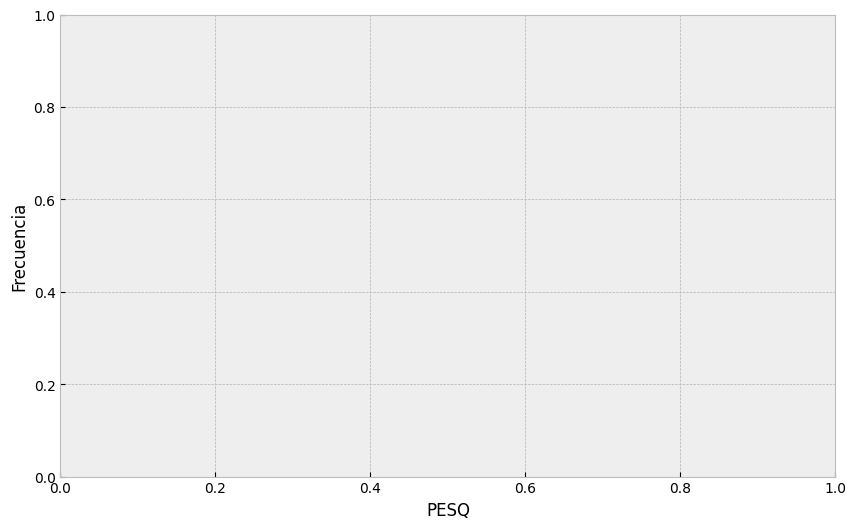

In [13]:
plt.style.use('bmh')
plt.figure(figsize=(10, 6))
plt.xlabel('PESQ', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

pesq_min = min(data[system]['pesq'].min() for system in systems)
pesq_max = max(data[system]['pesq'].max() for system in systems)

bins = np.linspace(pesq_min, pesq_max, 101)  # 50 bins, 51 edges

for system, df in data.items():
    sns.histplot(data=df, x='pesq', bins=bins, kde=True, stat='density', label=system, alpha=0.5)
plt.legend(title='Sistema')
plt.xlim([pesq_min, pesq_max])
plt.savefig(plots_folder / 'pesq_combined.svg')
plt.show()

Grafico de la relación señal a ruido

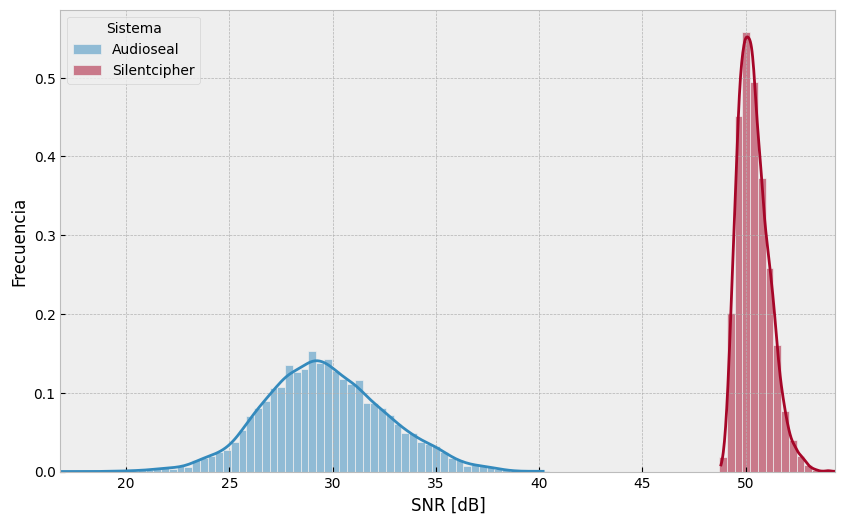

In [96]:
plt.style.use('bmh')
plt.figure(figsize=(10, 6))
plt.xlabel('SNR [dB]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

snr_min = min(data['Audioseal']['snr'].min(), data['Silentcipher']['snr'].min())
snr_max = max(data['Audioseal']['snr'].max(), data['Silentcipher']['snr'].max())

bins = np.linspace(snr_min, snr_max, 101)

for system, df in data.items():
    sns.histplot(data=df, x='snr', bins=bins, kde=True, stat='density', label=system, alpha=0.5)

plt.legend(title='Sistema')
plt.xlim([snr_min, snr_max])
plt.savefig('plots/snr_combined.svg')
plt.show()

Scatter plot de la relación entre SNR y PESQ para cada ataque

<Figure size 1000x600 with 0 Axes>

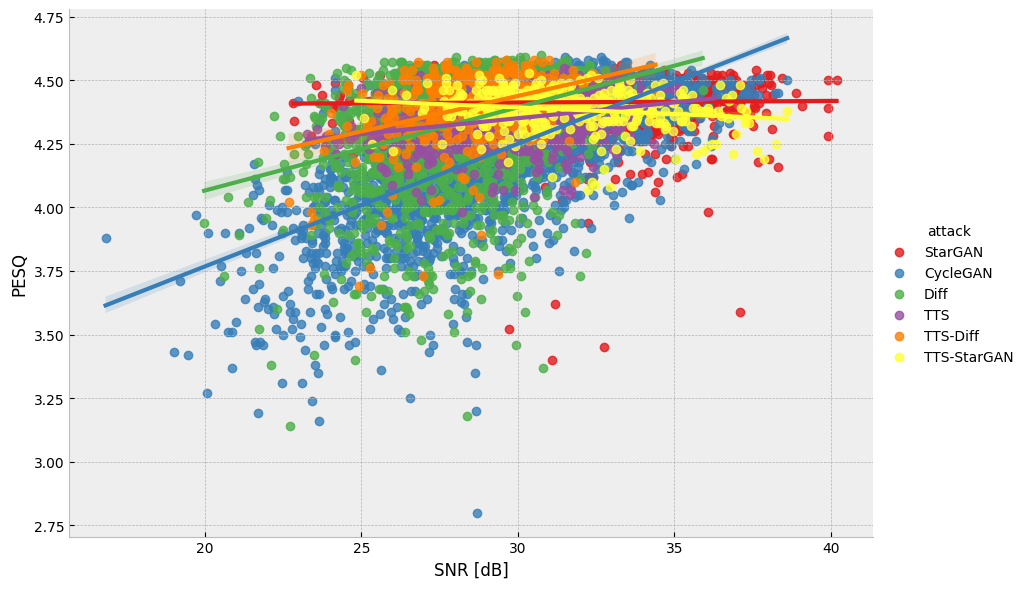

In [69]:
plt.style.use('bmh')
plt.figure(figsize=(10, 6))
sns.lmplot(x='snr', y='pesq', data=data['audioseal'], hue='attack', palette='Set1', markers='o', height=6, aspect=1.5)
plt.xlabel('SNR [dB]')
plt.ylabel('PESQ')
plt.savefig('plots/audioseal/snr-pesq.svg')
plt.show()


In [70]:
correlation, p_value = pearsonr(data['audioseal']['snr'], data['audioseal']['pesq'])
print(f'Coeficiente de correlación de Pearson: {correlation}')
print(f'Valor p: {p_value}')

model = ols('pesq ~ C(attack) + snr', data=data['audioseal']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

Coeficiente de correlación de Pearson: 0.4263899580182285
Valor p: 0.0
               sum_sq      df            F         PR(>F)
C(attack)   38.303875     5.0   305.271344  5.396491e-302
snr         43.504863     1.0  1733.608895   0.000000e+00
Residual   218.200761  8695.0          NaN            NaN


Plot del tiempo de inferencia de cada sistema

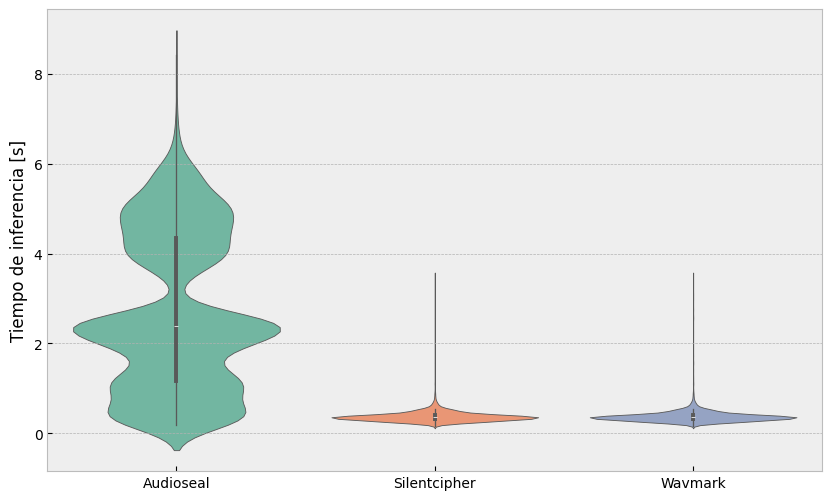

In [71]:
placeholder_data = pd.DataFrame({
    'time': pd.concat([data['audioseal']['time'], data['silentcipher']['time'], data['silentcipher']['time']]),
    'group': ['Audioseal'] * len(data['audioseal']) + ['Silentcipher'] * len(data['silentcipher']) + ['Wavmark'] * len(data['silentcipher'])
})

plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='time', hue='group', legend=False, data=placeholder_data, palette='Set2')
plt.ylabel('Tiempo de inferencia [s]')
plt.xlabel('')

plt.show()

Ahora voy a plotear el bit error rate para cada sistema

C:\Users\jalma\AppData\Local\Temp\ipykernel_14580\2653422662.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='System', y='BER', data=ber_df, palette='Set2')


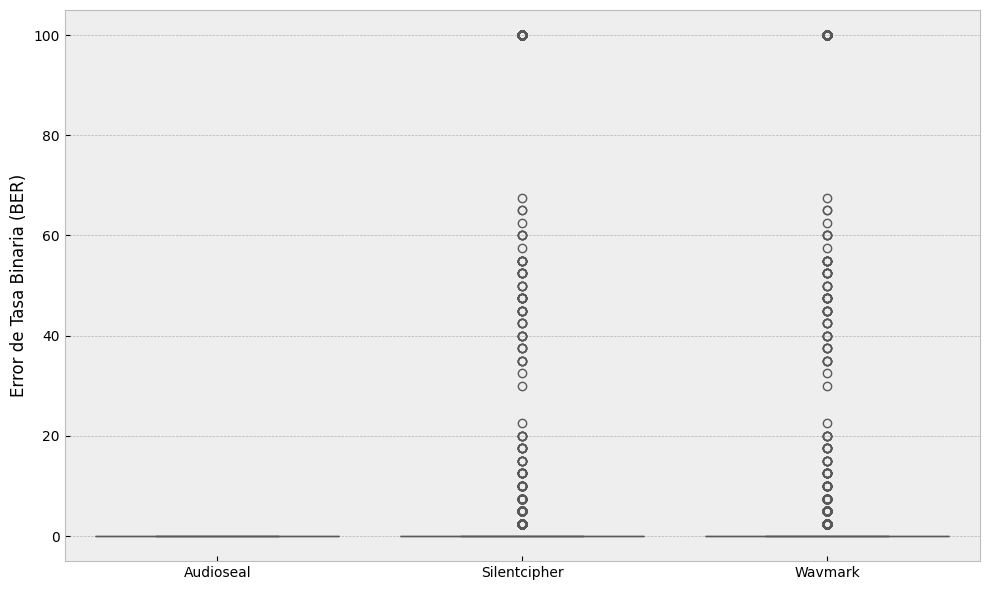

In [105]:
# Suponiendo que tienes un DataFrame que contiene los BER por sistema
ber_df = pd.DataFrame({
    'System': ['Audioseal'] * len(data['Audioseal']['ber']) + 
               ['Silentcipher'] * len(data['Silentcipher']['ber']) +
               ['Wavmark'] * len(data['Silentcipher']['ber']),
    'BER': list(data['Audioseal']['ber']) + list(data['Silentcipher']['ber']) + list(data['Silentcipher']['ber'])
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='System', y='BER', data=ber_df, palette='Set2')
plt.ylabel('Error de Tasa Binaria (BER)')
plt.xlabel('')
plt.tight_layout()
plt.show()

Ahora quiero plotear el tiempo de inferencia normalizado con respecto a la duración de cada archivo

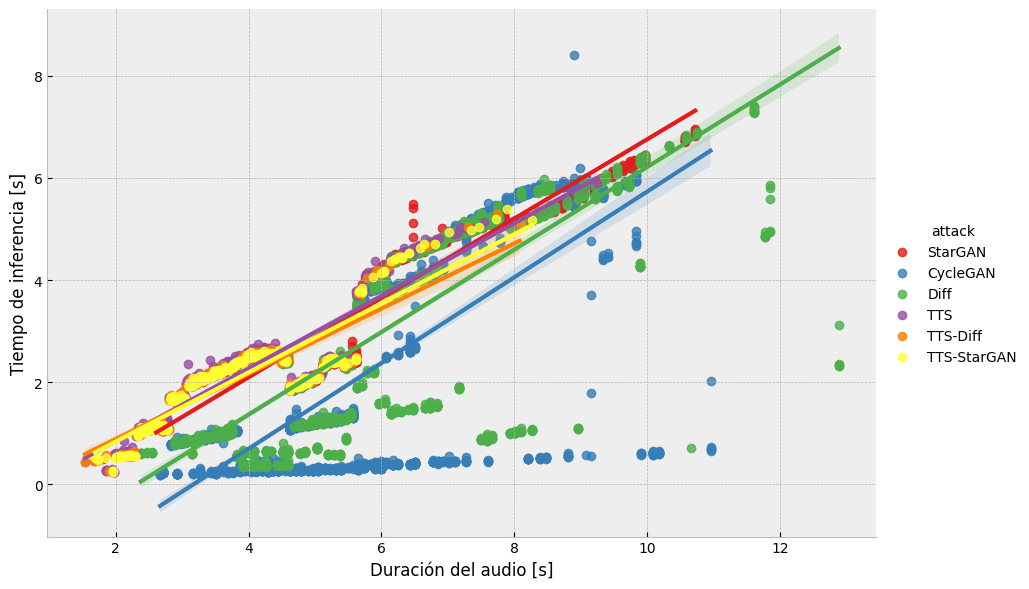

In [29]:
protocol_columns = ['speaker_id', 'file_name', 'attack', 'key', 'duration']
protocol_df = pd.read_csv('protocol-spoofed.txt', sep='\s+', header=None, names=protocol_columns)

results_df = data['Audioseal']

merged_df = pd.merge(results_df, protocol_df[['file_name', 'duration']], on='file_name')
merged_df['time_normalized'] = merged_df['time'] / merged_df['duration']
sns.lmplot(x='duration', y='time', data=merged_df, hue='attack', palette='Set1', markers='o', height=6, aspect=1.5)
plt.xlabel('Duración del audio [s]')
plt.ylabel('Tiempo de inferencia [s]')

# Mostrar el gráfico
plt.show()
